## **Library**

this notebook is modification from Onur koç's note book.

https://www.kaggle.com/code/onurkoc83/overfit-champion

I add
* some EDA
* smote
* count encoding

In [1]:
import optuna
from optuna.samplers import TPESampler

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, recall_score
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.pipeline import Pipeline
import category_encoders as ce

# Models
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold, RepeatedMultilabelStratifiedKFold
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier

import numpy as np
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

c:\python\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Load Data**

* load data
* concat two dataframe
* extract col/row that is needed

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
mixed_desc = pd.read_csv('mixed_desc.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [3]:
# concat two dataframe
# extract col/row that is needed
train.drop(columns=["id"],inplace=True)
test.drop(columns=["id"],inplace=True)
mixed_desc.drop(columns=["CIDs"],inplace=True)
col="EC1_EC2_EC3_EC4_EC5_EC6"

mixed_desc[col.split("_")]= mixed_desc[col].str.split('_', expand=True).astype(int)
mixed_desc.drop(col, axis=1, inplace=True)

original = mixed_desc[train.columns]

train = pd.concat([train,original]).reset_index(drop=True)
train.drop(columns=col.split("_")[2:],inplace=True)

In [4]:
train.shape, test.shape

((15877, 33), (9893, 31))

## **EDA**

* NA
* outlier
* correlation map
* feature distribution
* target distribution


In [5]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df) * 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['average'] = desc['mean'].values
    summ['standard_deviation'] = desc['std'].values
    
    return summ

pd.options.display.float_format = '{:,.2f}'.format
summary(train)

data shape: (15877, 33)


,data type,#missing,%missing,#unique,min,max,average,standard_deviation
BertzCT,float64,0,0.00,2375,0.00,"4,069.96",520.76,551.09
Chi1,float64,0,0.00,1267,0.00,73.27,9.22,6.98
Chi1n,float64,0,0.00,3184,0.00,58.85,5.92,4.78
Chi1v,float64,0,0.00,3323,0.00,61.91,6.82,5.99
Chi2n,float64,0,0.00,3665,0.00,43.05,4.49,3.86
Chi2v,float64,0,0.00,3752,0.00,45.43,5.32,5.02
Chi3v,float64,0,0.00,3460,0.00,30.33,3.47,3.51
Chi4n,float64,0,0.00,2948,0.00,20.41,1.81,1.93
EState_VSA1,float64,0,0.00,731,0.00,363.71,29.50,32.31
EState_VSA2,float64,0,0.00,446,0.00,99.94,10.58,13.86


* no NA data
* NumHeteroatoms, fr_COO, fr_COO2 are discrete form

In [6]:
features = [f for f in test.columns if not f.startswith('EC')]
int_feature_mask = (train[features] == train[features].astype(int)).all()
int_features = list(train[features].columns[int_feature_mask])
print("int features: ", int_features)
print()

float_features = list(train[features].columns[~int_feature_mask])
print("float features: ", float_features)

int features:  ['NumHeteroatoms', 'fr_COO', 'fr_COO2']

float features:  ['BertzCT', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3v', 'Chi4n', 'EState_VSA1', 'EState_VSA2', 'ExactMolWt', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'HallKierAlpha', 'HeavyAtomMolWt', 'Kappa3', 'MaxAbsEStateIndex', 'MinEStateIndex', 'PEOE_VSA10', 'PEOE_VSA14', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'SMR_VSA10', 'SMR_VSA5', 'SlogP_VSA3', 'VSA_EState9']


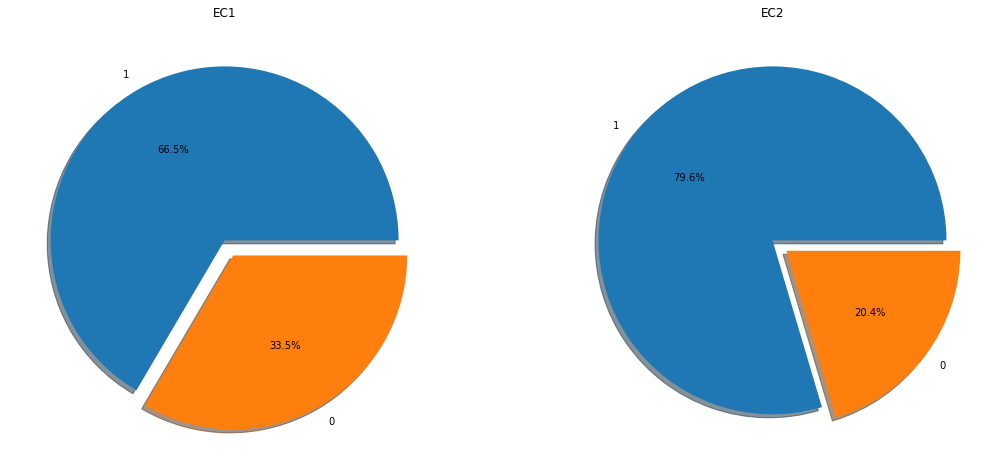

In [7]:
# distribution of target feature
f, ax = plt.subplots(1, 2, figsize=(18, 8))
train['EC1'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('EC1')
ax[0].set_ylabel('')
train['EC2'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[1],shadow=True)
ax[1].set_title('EC2')
ax[1].set_ylabel('')
plt.show()

a little unbalance, we will deal with it later

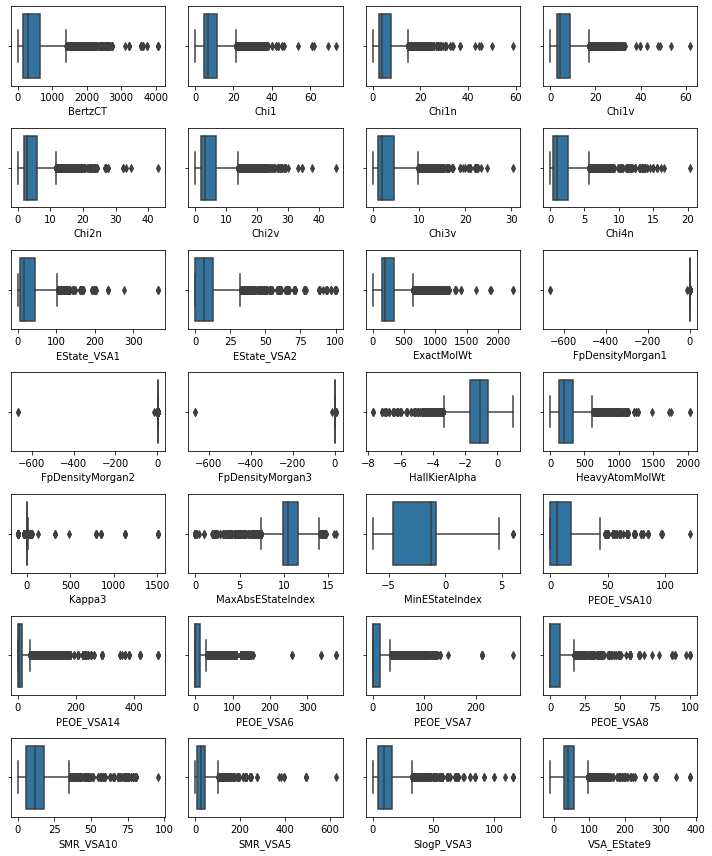

In [8]:
# distribution of other feature(boxplot)
fig, axs = plt.subplots(7, 4, figsize=(10, 12))
axs = axs.ravel()
for ax, f in zip(axs, float_features):
    sns.boxplot(data=train,x=train[f], ax=ax)
    
plt.tight_layout()
plt.show()

can find some feature with outliers

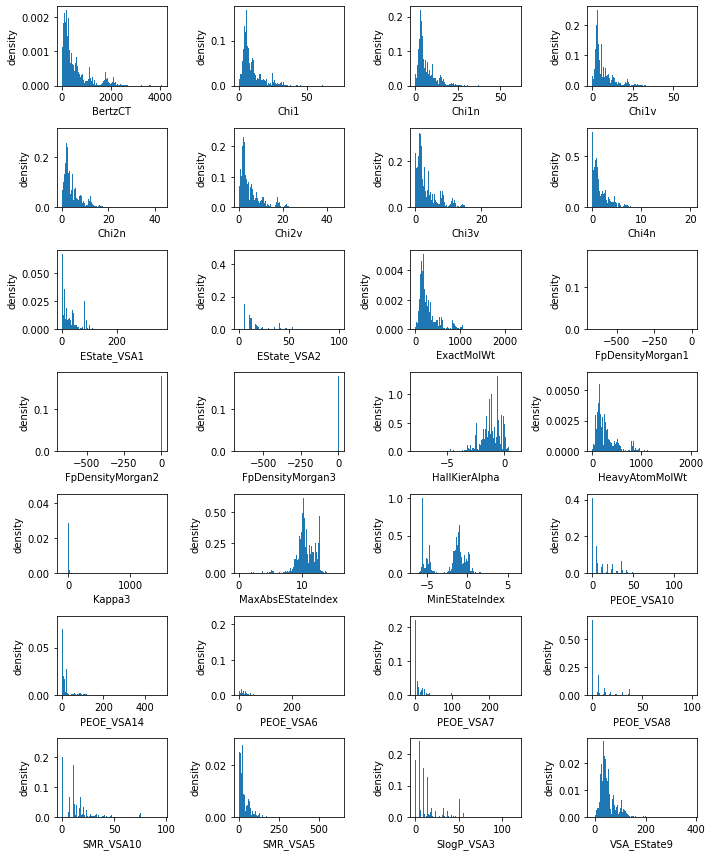

In [9]:
# distribution of other feature(histogram)
fig, axs = plt.subplots(7, 4, figsize=(10, 12))
axs = axs.ravel()
for ax, f in zip(axs, float_features):
    ax.hist(train[f], bins=120, density=True)
    ax.set_xlabel(f)
    ax.set_ylabel('density')
plt.tight_layout()
plt.show()

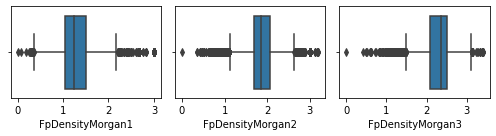

In [10]:
# remove outlier
train = train[train.FpDensityMorgan1 >= 0]
train = train[train.FpDensityMorgan2 >= 0]
train = train[train.FpDensityMorgan3 >= 0]

fig, axs = plt.subplots(1, 3, figsize=(7, 2))
axs = axs.ravel()
for ax, f in zip(axs, ['FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3']):
    sns.boxplot(data=train,x=train[f], ax=ax)
    
plt.tight_layout()
plt.show()

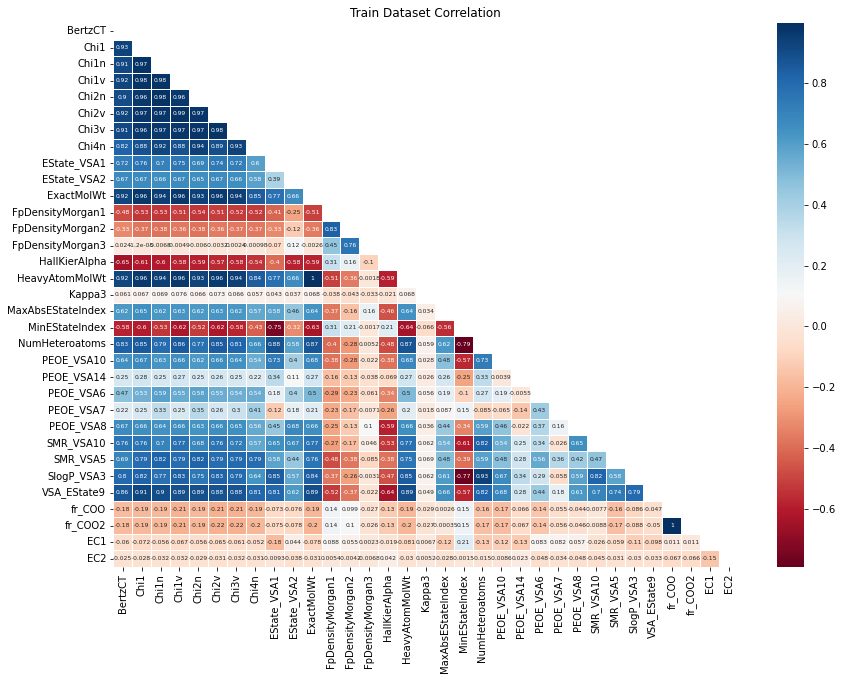

In [11]:
def plot_correlation_heatmap(df: pd.core.frame.DataFrame, title_name: str = 'Train correlation') -> None:
    # create excluded list
    excluded_columns = ['id', 'EC3', 'EC4', 'EC5', 'EC6']
    
    # Create a list of columns excluding the excluded_columns.
    columns_without_excluded = [col for col in df.columns if col not in excluded_columns]
    
    corr = df[columns_without_excluded].corr()
    fig, axes = plt.subplots(figsize=(14, 10))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=.5, cmap=plt.cm.RdBu, annot=True, annot_kws={"size": 6})
    plt.title(title_name)
    plt.show()

plot_correlation_heatmap(train, 'Train Dataset Correlation')

## **Data Augumentation**

* target encoding
* count encoding
* other data augumentation

In [12]:
def generate_features(train, test, cat_cols, num_cols):
    features = cat_cols + num_cols
    df = pd.concat([train, test], axis = 0, copy = False)
    
    for c in cat_cols + num_cols:
        
        df[f'count_{c}'] = df.groupby(c)[c].transform('count')
        features.append(f'count_{c}')
    for c in cat_cols:
        for n in num_cols:
                df[f'mean_{n}_per_{c}'] = df.groupby(c)[n].transform('mean')
                features.append(f'mean_{n}_per_{c}')
            
    return df.iloc[:len(train),:], df.iloc[len(train):, :],features

target_cols = ['EC1', 'EC2']
train_target = ['EC1', 'EC2']
cols_to_drop = ['id']
cat_cols = int_features
num_cols = float_features
train_df,test_df,features_new = generate_features(train,test,cat_cols,num_cols)

In [13]:
# target encoder(https://www.kaggle.com/code/meisa0/s3e18-target-encoding-lb-0-65947)
def convert_to_cat(value):
    if value in dic:
        return dic[value]
    else:
        return 9999

import collections
train_df_num_rows = train_df.shape[0]
target_encoder = {}
for col in cat_cols:

    cnt = 0
    dic = {}
    for i,(key,value) in enumerate(collections.Counter(list(train_df[col])).most_common()):
        cnt += value
        dic[key] = i
        if cnt / train_df_num_rows > 0.7:
            break
    print(dic)
    
    train_df[f"{col}_cat"] = pd.Categorical(train_df[col].map(convert_to_cat))
    test_df[f"{col}_cat"] = pd.Categorical(test_df[col].map(convert_to_cat))
    
    
    target_mean = train_df.groupby(f"{col}_cat")[train_target].mean()
    target_encoder[col] = target_mean
    
    train_df[f'{col}_ec1_encoded'] = train_df[f"{col}_cat"].map(target_mean["EC1"]).astype('float64')
    train_df[f'{col}_ec2_encoded'] = train_df[f"{col}_cat"].map(target_mean["EC2"]).astype('float64')
    
    test_df[f'{col}_ec1_encoded'] = test_df[f"{col}_cat"].map(target_mean["EC1"]).astype('float64')
    test_df[f'{col}_ec2_encoded'] = test_df[f"{col}_cat"].map(target_mean["EC2"]).astype('float64')
    
    del train_df[f"{col}_cat"]
    del test_df[f"{col}_cat"]

{4: 0, 3: 1, 5: 2, 6: 3, 2: 4, 7: 5, 10: 6, 9: 7, 8: 8}
{0: 0, 1: 1}
{0: 0, 1: 1}


In [14]:
# count encoder
encoder = ce.CountEncoder(cols=cat_cols)
train_encoder = encoder.fit_transform(train_df[cat_cols]).astype(int).add_suffix('_count')
test_encoder = encoder.transform(test_df[cat_cols]).astype(int).add_suffix('_count')
train_df = pd.concat([train_df, train_encoder], axis=1)
test_df = pd.concat([test_df, test_encoder], axis=1)


In [15]:
features = [c for c in train_df.columns if c not in target_cols + cols_to_drop]
X_train = train_df[features]
Y_train = train_df[target_cols]
X_test = test_df[features]
y  = Y_train
X  = X_train

## **Model**

In [35]:
# XGBoost classifier parameters
xgb_params = {'n_estimators': 100,
              'tree_method': 'hist',
              'max_depth': 4,
              'reg_alpha': 0.06790740746476749,
              'reg_lambda': 0.03393770327994609,
              'min_child_weight': 1,
              'gamma': 2.5705812096617772e-05,
              'learning_rate': 0.07132617944894756,
              'colsample_bytree': 0.11664298814833247,
              'colsample_bynode': 0.9912092923877247,
              'colsample_bylevel': 0.29178614622079735,
              'subsample': 0.7395301853144935,
              'random_state': 42
              }

# LightGBM classifier parameters
lgbm_params = {'n_estimators': 200,
 'boosting_type': 'gbdt',
 'max_depth': 10,
 'reg_alpha': 6.720380454685094,
 'reg_lambda': 7.074828689930955e-05,
 'min_child_samples': 15,
 'subsample': 0.5182995486972547,
 'learning_rate': 0.027352422199502537,
 'colsample_bytree': 0.2257179878033366,
 'colsample_bynode': 0.7098194984886731,
 'random_state': 84315}

# Define the classifiers
xgb_classifier = MultiOutputClassifier(XGBClassifier(**xgb_params))
lgbm_classifier = MultiOutputClassifier(LGBMClassifier(**lgbm_params))

# Create the pipelines
xgb_clf = Pipeline([('classifier', xgb_classifier)])
lgbm_clf = Pipeline([('classifier', lgbm_classifier)])

# Initialize variables
oof_preds_xgb = np.zeros(y.shape)
oof_preds_lgbm = np.zeros(y.shape)
test_preds_xgb = np.zeros((test.shape[0], y.shape[1]))
test_preds_lgbm = np.zeros((test.shape[0], y.shape[1]))
oof_losses_xgb = []
oof_losses_lgbm = []
n_splits = 5
kf = RepeatedMultilabelStratifiedKFold(n_splits=n_splits, n_repeats=1, random_state=42)
train_losses_xgb = []
train_losses_lgbm = []
over_train=[]
over_valid=[]
over_train1=[]
over_valid1=[]
over_train2=[]
over_valid2=[]
# Loop over folds
for fn, (trn_idx, val_idx) in enumerate(kf.split(X, y)):
    print('Starting fold:', fn)
    X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[trn_idx], y.iloc[val_idx]

    # Train and predict with XGBoost classifier
    xgb_clf.fit(X_train, y_train)
    train_preds_xgb = xgb_clf.predict_proba(X_train)
    train_preds_xgb = np.array(train_preds_xgb)[:, :, 1].T
    #train_loss_xgb = roc_auc_score(np.ravel(y_train), np.ravel(train_preds_xgb))
    #train_losses_xgb.append(train_loss_xgb)

    val_preds_xgb = xgb_clf.predict_proba(X_val)
    val_preds_xgb = np.array(val_preds_xgb)[:, :, 1].T
    oof_preds_xgb[val_idx] = val_preds_xgb
    loss_xgb = roc_auc_score(np.ravel(y_val), np.ravel(val_preds_xgb))
    oof_losses_xgb.append(loss_xgb)
    preds_xgb = xgb_clf.predict_proba(X_test)
    preds_xgb = np.array(preds_xgb)[:, :, 1].T
    test_preds_xgb += preds_xgb / n_splits

    

    # Train and predict with LightGBM classifier
    lgbm_clf.fit(X_train, y_train)
    train_preds_lgbm = lgbm_clf.predict_proba(X_train)
    train_preds_lgbm = np.array(train_preds_lgbm)[:, :, 1].T
    #train_loss_lgbm = roc_auc_score(np.ravel(y_train), np.ravel(train_preds_lgbm))
    #train_losses_lgbm.append(train_loss_lgbm)

    val_preds_lgbm = lgbm_clf.predict_proba(X_val)
    val_preds_lgbm = np.array(val_preds_lgbm)[:, :, 1].T
    oof_preds_lgbm[val_idx] = val_preds_lgbm

    loss_lgbm = roc_auc_score(np.ravel(y_val), np.ravel(val_preds_lgbm))
    oof_losses_lgbm.append(loss_lgbm)
    preds_lgbm = lgbm_clf.predict_proba(X_test)
    preds_lgbm = np.array(preds_lgbm)[:, :, 1].T
    test_preds_lgbm += preds_lgbm / n_splits
    overall_train_preds = (train_preds_xgb+train_preds_lgbm)/2
    overall_train_loss = roc_auc_score(np.ravel(y_train), np.ravel(overall_train_preds))
    overall_valid_preds = (val_preds_xgb+val_preds_lgbm)/2
    overall_valid_loss = roc_auc_score(np.ravel(y_val), np.ravel(overall_valid_preds))
    over_train.append(overall_train_loss)
    over_valid.append(overall_valid_loss)
    print("overall_train_loss",overall_train_loss)
    print("overall_valid_loss",overall_valid_loss)
    overall_train_loss = recall_score(zero2one(np.ravel(y_train)), zero2one(np.floor(np.ravel(overall_train_preds) + 0.5)))
    overall_valid_loss = recall_score(zero2one(np.ravel(y_val)), zero2one(np.floor(np.ravel(overall_valid_preds) + 0.5)))
    over_train1.append(overall_train_loss)
    over_valid1.append(overall_valid_loss)
    print("overall_train_loss_recall",overall_train_loss)
    print("overall_valid_loss_recall",overall_valid_loss)
    overall_train_loss = recall_score(np.ravel(y_train), np.floor(np.ravel(overall_train_preds) + 0.5))
    overall_valid_loss = recall_score(np.ravel(y_val), np.floor(np.ravel(overall_valid_preds) + 0.5))
    over_train2.append(overall_train_loss)
    over_valid2.append(overall_valid_loss)
    print("overall_train_loss_spec",overall_train_loss)
    print("overall_valid_loss_spec",overall_valid_loss)

print("over_train",np.mean(over_train))
print("over_valid",np.mean(over_valid))
print("over_train_recall",np.mean(over_train1))
print("over_valid_recall",np.mean(over_valid1))
print("over_train_spec",np.mean(over_train2))
print("over_valid_spec",np.mean(over_valid2))

Starting fold: 0
overall_train_loss 0.7858148740989608
overall_valid_loss 0.6840581084539339
overall_train_loss_recall 0.2810992544949569
overall_valid_loss_recall 0.23130841121495327
overall_train_loss_spec 0.9521910203201639
overall_valid_loss_spec 0.9368262181974989
Starting fold: 1
overall_train_loss 0.7820804710310301
overall_valid_loss 0.6916411679546104
overall_train_loss_recall 0.2676118094124525
overall_valid_loss_recall 0.2314436002337814
overall_train_loss_spec 0.9560694264769297
overall_valid_loss_spec 0.9469713300280233
Starting fold: 2
overall_train_loss 0.7823988874320574
overall_valid_loss 0.6927192478104849
overall_train_loss_recall 0.2748794388426129
overall_valid_loss_recall 0.23684210526315788
overall_train_loss_spec 0.9543470058750606
overall_valid_loss_spec 0.9432945235015092
Starting fold: 3
overall_train_loss 0.7819108605834683
overall_valid_loss 0.6827709816441347
overall_train_loss_recall 0.27356422621657167
overall_valid_loss_recall 0.24561403508771928
overal

In [ ]:
sample_submission.iloc[:,1:] = (test_preds_xgb+test_preds_lgbm)/2
sample_submission.to_csv("submission_7_9_0.csv",index=False)

In [36]:
# smote
def smote_train_data(X_train, y):

    y_label = np.zeros(y.shape[0])
    y_label[(y['EC1'] == 1) & (y['EC2'] == 0)] = 1
    y_label[(y['EC1'] == 0) & (y['EC2'] == 1)] = 2
    y_label[(y['EC1'] == 0) & (y['EC2'] == 0)] = 3
    from sklearn.preprocessing import LabelEncoder
    y_label = LabelEncoder().fit_transform(y_label)

    #print(pd.crosstab(y.EC1, y.EC2))
    #print("Before OverSampling, counts of label '0': {}".format(sum(y_label == 0)))
    #print("Before OverSampling, counts of label '1': {} \n".format(sum(y_label == 1)))
    #print("Before OverSampling, counts of label '2': {} \n".format(sum(y_label == 2)))
    #print("Before OverSampling, counts of label '3': {} \n".format(sum(y_label == 3)))
    
    # import SMOTE module from imblearn library
    # pip install imblearn (if you don't have imblearn in your system)
    from imblearn.over_sampling import SMOTE
    oversample = SMOTE()
    X_smote, y_label = oversample.fit_resample(X_train, y_label)
    #print("Before OverSampling, counts of label '0': {}".format(sum(y_label == 0)))
    #print("Before OverSampling, counts of label '1': {} \n".format(sum(y_label == 1)))
    #print("Before OverSampling, counts of label '2': {} \n".format(sum(y_label == 2)))
    #print("Before OverSampling, counts of label '3': {} \n".format(sum(y_label == 3)))
    y_smote = pd.DataFrame(np.zeros((y_label.shape[0], y.shape[1])))
    y_smote[y_label == 0] = [1, 1]
    y_smote[y_label == 1] = [1, 0]
    y_smote[y_label == 2] = [0, 1]
    y_smote.columns = ['EC1', 'EC2']
    pd.crosstab(y_smote.EC1, y_smote.EC2)
    #X_test = test_df[features]
    #y  = y_smote
    #X  = X_smote
    return X_smote, y_smote

def zero2one(x):
    
    return np.floor(1 - x/2)

In [37]:
# model with smote
# XGBoost classifier parameters
xgb_params = {'n_estimators': 100,
              'tree_method': 'hist',
              'max_depth': 4,
              'reg_alpha': 0.06790740746476749,
              'reg_lambda': 0.03393770327994609,
              'min_child_weight': 1,
              'gamma': 2.5705812096617772e-05,
              'learning_rate': 0.07132617944894756,
              'colsample_bytree': 0.11664298814833247,
              'colsample_bynode': 0.9912092923877247,
              'colsample_bylevel': 0.29178614622079735,
              'subsample': 0.7395301853144935,
              'random_state': 42
              }

# LightGBM classifier parameters
lgbm_params = {'n_estimators': 200,
 'boosting_type': 'gbdt',
 'max_depth': 10,
 'reg_alpha': 6.720380454685094,
 'reg_lambda': 7.074828689930955e-05,
 'min_child_samples': 15,
 'subsample': 0.5182995486972547,
 'learning_rate': 0.027352422199502537,
 'colsample_bytree': 0.2257179878033366,
 'colsample_bynode': 0.7098194984886731,
 'random_state': 84315}

# Define the classifiers
xgb_classifier = MultiOutputClassifier(XGBClassifier(**xgb_params))
lgbm_classifier = MultiOutputClassifier(LGBMClassifier(**lgbm_params))

# Create the pipelines
xgb_clf = Pipeline([('classifier', xgb_classifier)])
lgbm_clf = Pipeline([('classifier', lgbm_classifier)])

# Initialize variables
oof_preds_xgb = np.zeros(y.shape)
oof_preds_lgbm = np.zeros(y.shape)
test_preds_xgb = np.zeros((test.shape[0], y.shape[1]))
test_preds_lgbm = np.zeros((test.shape[0], y.shape[1]))
oof_losses_xgb = []
oof_losses_lgbm = []
n_splits = 5
kf = RepeatedMultilabelStratifiedKFold(n_splits=n_splits, n_repeats=1, random_state=42)
train_losses_xgb = []
train_losses_lgbm = []
over_train=[]
over_valid=[]
over_train1=[]
over_valid1=[]
# Loop over folds
for fn, (trn_idx, val_idx) in enumerate(kf.split(X, y)):
    print('Starting fold:', fn)
    X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[trn_idx], y.iloc[val_idx]
    X_train, y_train = smote_train_data(X_train, y_train)

    # Train and predict with XGBoost classifier
    xgb_clf.fit(X_train, y_train)
    train_preds_xgb = xgb_clf.predict_proba(X_train)
    train_preds_xgb = np.array(train_preds_xgb)[:, :, 1].T
    #train_loss_xgb = roc_auc_score(np.ravel(y_train), np.ravel(train_preds_xgb))
    #train_losses_xgb.append(train_loss_xgb)

    val_preds_xgb = xgb_clf.predict_proba(X_val)
    val_preds_xgb = np.array(val_preds_xgb)[:, :, 1].T
    oof_preds_xgb[val_idx] = val_preds_xgb
    loss_xgb = roc_auc_score(np.ravel(y_val), np.ravel(val_preds_xgb))
    oof_losses_xgb.append(loss_xgb)
    preds_xgb = xgb_clf.predict_proba(X_test)
    preds_xgb = np.array(preds_xgb)[:, :, 1].T
    test_preds_xgb += preds_xgb / n_splits

    

    # Train and predict with LightGBM classifier
    lgbm_clf.fit(X_train, y_train)
    train_preds_lgbm = lgbm_clf.predict_proba(X_train)
    train_preds_lgbm = np.array(train_preds_lgbm)[:, :, 1].T
    #train_loss_lgbm = roc_auc_score(np.ravel(y_train), np.ravel(train_preds_lgbm))
    #train_losses_lgbm.append(train_loss_lgbm)

    val_preds_lgbm = lgbm_clf.predict_proba(X_val)
    val_preds_lgbm = np.array(val_preds_lgbm)[:, :, 1].T
    oof_preds_lgbm[val_idx] = val_preds_lgbm

    loss_lgbm = roc_auc_score(np.ravel(y_val), np.ravel(val_preds_lgbm))
    oof_losses_lgbm.append(loss_lgbm)
    preds_lgbm = lgbm_clf.predict_proba(X_test)
    preds_lgbm = np.array(preds_lgbm)[:, :, 1].T
    test_preds_lgbm += preds_lgbm / n_splits
    overall_train_preds = (train_preds_xgb+train_preds_lgbm)/2
    overall_train_loss = roc_auc_score(np.ravel(y_train), np.ravel(overall_train_preds))
    overall_valid_preds = (val_preds_xgb+val_preds_lgbm)/2
    overall_valid_loss = roc_auc_score(np.ravel(y_val), np.ravel(overall_valid_preds))
    over_train.append(overall_train_loss)
    over_valid.append(overall_valid_loss)
    print("overall_train_loss",overall_train_loss)
    print("overall_valid_loss",overall_valid_loss)
    overall_train_loss = recall_score(zero2one(np.ravel(y_train)), zero2one(np.floor(np.ravel(overall_train_preds) + 0.5)))
    overall_valid_loss = recall_score(zero2one(np.ravel(y_val)), zero2one(np.floor(np.ravel(overall_valid_preds) + 0.5)))
    over_train1.append(overall_train_loss)
    over_valid1.append(overall_valid_loss)
    print("overall_train_loss_recall",overall_train_loss)
    print("overall_valid_loss_recall",overall_valid_loss)
    overall_train_loss = recall_score(np.ravel(y_train), np.floor(np.ravel(overall_train_preds) + 0.5))
    overall_valid_loss = recall_score(np.ravel(y_val), np.floor(np.ravel(overall_valid_preds) + 0.5))
    over_train2.append(overall_train_loss)
    over_valid2.append(overall_valid_loss)
    print("overall_train_loss_spec",overall_train_loss)
    print("overall_valid_loss_spec",overall_valid_loss)

print("over_train",np.mean(over_train))
print("over_valid",np.mean(over_valid))
print("over_train_recall",np.mean(over_train1))
print("over_valid_recall",np.mean(over_valid1))
print("over_train_spec",np.mean(over_train2))
print("over_valid_spec",np.mean(over_valid2))


Starting fold: 0
overall_train_loss 0.8484334770933855
overall_valid_loss 0.6624967129523279
overall_train_loss_recall 0.7673981191222571
overall_valid_loss_recall 0.3522196261682243
overall_train_loss_spec 0.7921238244514106
overall_valid_loss_spec 0.8648124191461837
Starting fold: 1
overall_train_loss 0.8498359405661635
overall_valid_loss 0.6675275146085037
overall_train_loss_recall 0.7684614168247944
overall_valid_loss_recall 0.34424313267095263
overall_train_loss_spec 0.7941176470588235
overall_valid_loss_spec 0.883811166199612
Starting fold: 2
overall_train_loss 0.8466644486607102
overall_valid_loss 0.6745608361135699
overall_train_loss_recall 0.7701140446805187
overall_valid_loss_recall 0.3672514619883041
overall_train_loss_spec 0.7838228401812217
overall_valid_loss_spec 0.8691246226821906
Starting fold: 3
overall_train_loss 0.8495090076639774
overall_valid_loss 0.6694698511407166
overall_train_loss_recall 0.7711784193090393
overall_valid_loss_recall 0.3649122807017544
overall_tr

In [29]:
sample_submission.iloc[:,1:] = (test_preds_xgb+test_preds_lgbm)/2
sample_submission.to_csv("submission_7_9_smote_2.csv",index=False)